In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [7]:
import numpy as np
import pandas as pd
import os
from random import randint
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

In [2]:
model = load_model('keras.model')

W0809 11:08:47.743748 16940 deprecation_wrapper.py:119] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 11:08:47.792719 16940 deprecation_wrapper.py:119] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 11:08:47.825714 16940 deprecation_wrapper.py:119] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0809 11:08:47.827699 16940 deprecation_wrapper.py:119] From C:\Users\Andrei.Brasoveanu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph i

In [11]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [9]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [13]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs
x_test = np.array([upsample(np.array(load_img("test/images/{}.png".format(idx), color_mode="grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)
preds_test = model.predict(x_test)
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > 0.7551020408163265)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

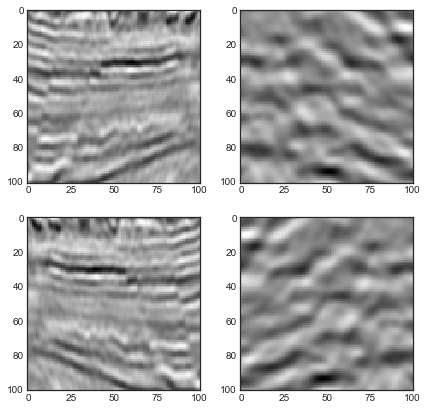

In [41]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2

img = cv2.imread('train/images/00cda0328c.png') /255
img2 = cv2.imread('train/images/000e218f21.png') /255
aug = iaa.Fliplr(1)
imga, imga2 = aug.augment_images([img, img2])
f, ax = plt.subplots(2,2, figsize=(7,7))
ax[0][0].imshow(img)
ax[0][1].imshow(img2)
ax[1][0].imshow(imga)
ax[1][1].imshow(imga2)

In [63]:
def scale(image_set, mask_set):
    aug = iaa.Affine(scale=1.2674)

    imgs = aug.augment_images(image_set)
    masks = aug.augment_images(mask_set)
    return imgs, masks

(101, 101)

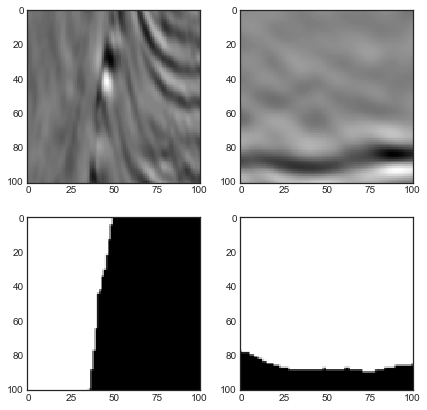

In [66]:
img = cv2.imread('train/images/0ba541766e.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('train/images/0bca43f7ff.png', cv2.IMREAD_GRAYSCALE) 
mask1 = cv2.imread('train/masks/0ba541766e.png', cv2.IMREAD_GRAYSCALE) 
mask2 = cv2.imread('train/masks/0bca43f7ff.png', cv2.IMREAD_GRAYSCALE) 
imgs, masks = scale([img, img2], [mask1, mask2])
f, ax = plt.subplots(2,2, figsize=(7,7))
ax[0][0].imshow(imgs[0], cmap='gray')
ax[0][1].imshow(imgs[1], cmap='gray')
ax[1][0].imshow(masks[0], cmap='gray')
ax[1][1].imshow(masks[1], cmap='gray')